<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/Find_CompProfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
import csv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1D Composition Profile Plot

## Extract Data and Name Variables

In [ ]:
# Experimental Data (RMC Reconstruction)
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Au50Pd50_Profiles_v2/RMC_Dt1000_1-10-10_v5/1-10.stru"
# Reference Data File (MC Target)
file_ref = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Au50Pd50_Profiles_v2/MC_Dt1000/2000_voidless.stru"
# Save file names

plotTitle = r'RMC Au50Pd50 Dt1000(Run5): 100 Cycles'
plotsavename_by_atom = 'RMC_Au50Pd50_Dt1000(Run5)_CP_by_atom.png'
plotsavename_by_rad = 'RMC_Au50Pd50_Dt1000(Run5)_CP_by_rad.png'
csvsavename_by_atom = 'Au50Pd50_RMC_Dt1000(Run5)_1D_CP_by_atom.csv'
csvsavename_by_rad = 'Au50Pd50_RMC_Dt1000(Run5)_1D_CP_by_rad.csv'
# Reference Atom
atom = 'AU'

In [ ]:
################################################################################
# Extract Experimental Data (RMC)
################################################################################
data = pd.read_csv(file, skiprows=3)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data = data[data.atom!='VOID']
data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)
data["distance"] = np.sqrt((data["x"]*data["x"] + data["y"]*data["y"] + data["z"]*data["z"])*(4.0789*4.0789))
# Output relevant structural info
print("Max distance in angstroms "+str(round(data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract Reference Data (MMC)
################################################################################
data_ref = pd.read_csv(file_ref, skiprows=3)
data_ref = data_ref.drop(data_ref.columns[3:], axis=1)
data_ref[["atoms", "x"]] = data_ref[data_ref.columns[0]].str.split(expand=True)
data_ref = data_ref.drop(data_ref.columns[0], axis=1)
data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data_ref = data_ref[data_ref.atom!='VOID']
data_ref["x"] = data_ref["x"].astype(float)
data_ref["y"] = data_ref["y"].astype(float)
data_ref["z"] = data_ref["z"].astype(float)
data_ref["distance"] = np.sqrt((data_ref["x"]*data_ref["x"] + data_ref["y"]*data_ref["y"] + data_ref["z"]*data_ref["z"])*(4.0789*4.0789))
# Output relevant structural info
print("Max distance in angstroms "+str(round(data_ref["distance"].max(),5)) +" - MC Ref")
print("Min distance in angstroms "+str(round(data_ref["distance"].min(),5)) +" - MC Ref")

Max distance in angstroms 28.83677 - RMC Data
Min distance in angstroms 0.16328 - RMC Data
Max distance in angstroms 25.1565 - MC Ref
Min distance in angstroms 0.07203 - MC Ref


<ipython-input-44-51ce9022fd2e>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
<ipython-input-44-51ce9022fd2e>:24: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


### Bin Data by Similar Number of Atoms

In [ ]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of maximum radius
RMC_Bins = []
MMC_Bins = []
RMC_Pd_counts = []
RMC_Au_counts = []
MMC_Pd_counts = []
MMC_Au_counts = []
for i in range(25):
    RMC_temp = data.nsmallest(157*(i+1), "distance")[-157:]
    MMC_temp = data_ref.nsmallest(157*(i+1), "distance")[-157:]

    RMC_Bins.append(RMC_temp["distance"].mean())
    MMC_Bins.append(MMC_temp["distance"].mean())

    RMC_Au_count = len(RMC_temp[RMC_temp["atom"]=="AU"])
    RMC_Pd_count = len(RMC_temp[RMC_temp["atom"]=="PD"])
    MMC_Au_count = len(MMC_temp[MMC_temp["atom"]=="AU"])
    MMC_Pd_count = len(MMC_temp[MMC_temp["atom"]=="PD"])

    RMC_Au_counts.append(RMC_Au_count/(len(RMC_temp)))
    RMC_Pd_counts.append(RMC_Pd_count/(len(RMC_temp)))
    MMC_Au_counts.append(MMC_Au_count/(len(MMC_temp)))
    MMC_Pd_counts.append(MMC_Pd_count/(len(MMC_temp)))

### Bin Data by Radial Distance

In [ ]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of custom max radius
numbin = 15

realBins = np.around(np.linspace(0,26,numbin),decimals=2)

data["bin"] = pd.cut(data["distance"], bins=realBins, right=False, precision=2,include_lowest='True',labels=realBins[1:])
data["bin"] = data["bin"].astype(float)
data_ref["bin"] = pd.cut(data_ref["distance"], bins=realBins, right=False, precision=2,include_lowest='True',labels=realBins[1:])
data_ref["bin"] = data_ref["bin"].astype(float)
data = data[["atom","x","y","z","distance","bin"]]
data_ref = data_ref[["atom","x","y","z","distance","bin"]]
################################################################################
# Group atom type by bin in order to plot
################################################################################
data_grouped = (data.groupby("bin")["atom"].value_counts(normalize=True).unstack()).fillna(0)
data_ref_grouped = (data_ref.groupby("bin")["atom"].value_counts(normalize=True).unstack()).fillna(0)
################################################################################
# Output atom/bin grouping info to reference
################################################################################
print("RMC DATA")
print("BIN     #Atoms")
print(data.bin.value_counts())
print("MC DATA")
print("BIN     #Atoms")
print(data_ref.bin.value_counts())

RMC DATA
BIN     #Atoms
24.14    728
22.29    629
20.43    557
26.00    407
18.57    388
16.71    368
14.86    256
13.00    205
11.14    151
9.29     109
7.43      46
5.57      31
3.71      12
1.86       1
Name: bin, dtype: int64
MC DATA
BIN     #Atoms
24.14    742
22.29    652
20.43    561
26.00    398
18.57    395
16.71    357
14.86    264
13.00    205
11.14    150
9.29     113
7.43      45
5.57      30
3.71      12
1.86       1
Name: bin, dtype: int64


## Make Composition Profile Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

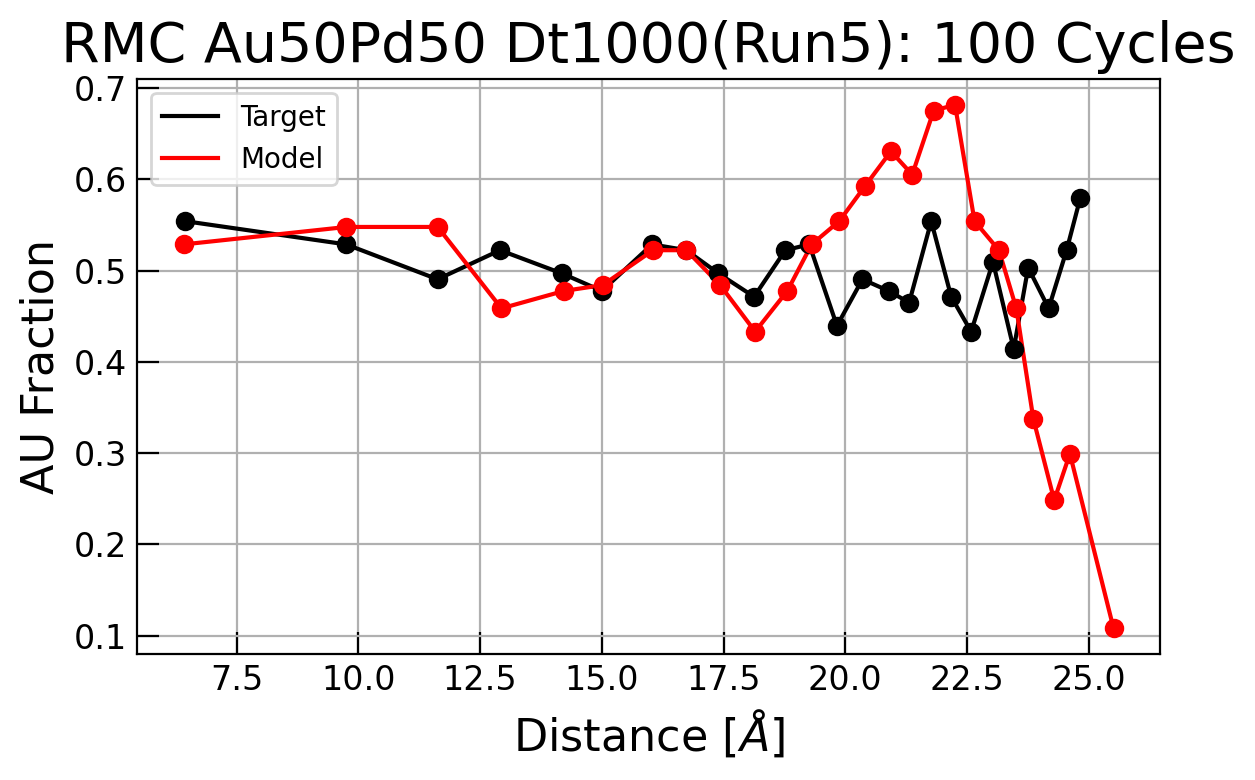

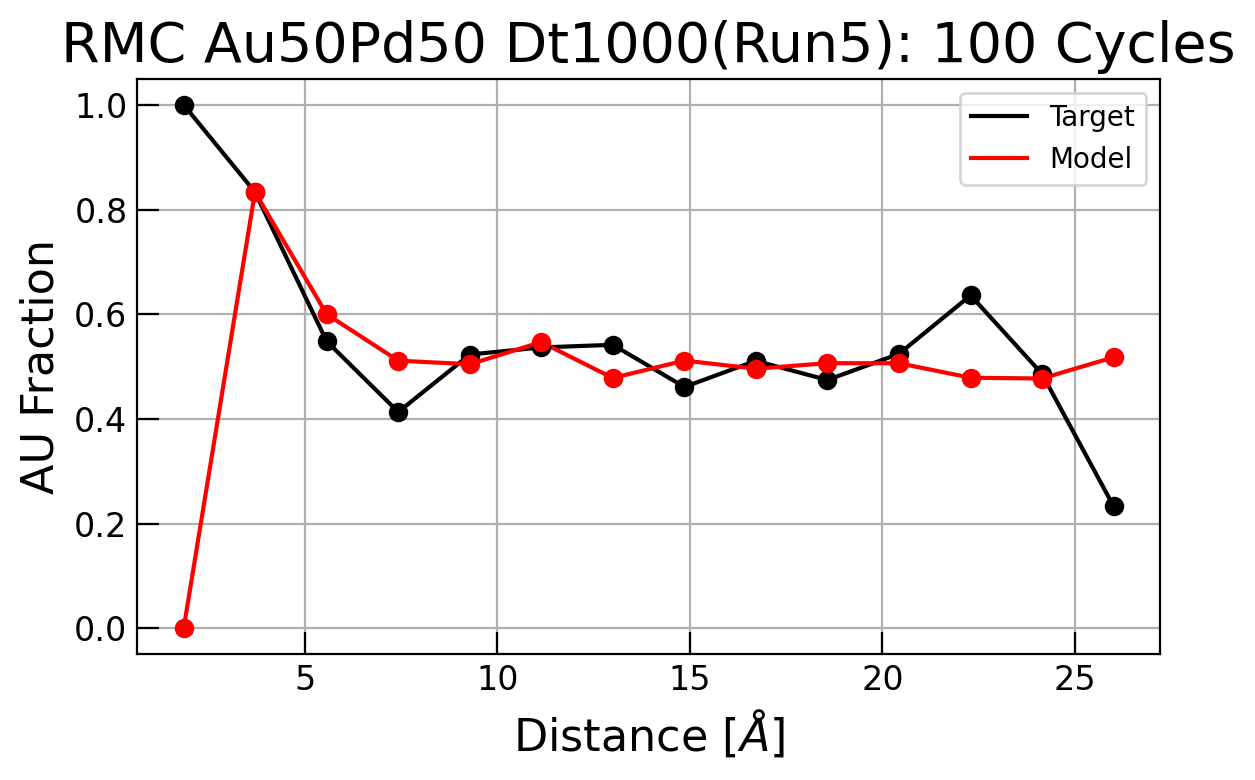

In [ ]:
################################################################################
# Plot Data by Atom
################################################################################
fig1, ax1 = plt.subplots(figsize=(6,4,),dpi=200)
ax1.plot(MMC_Bins,MMC_Au_counts, color='black', label = "Target", zorder=1)
ax1.plot(RMC_Bins,RMC_Au_counts, color='red', label = "Model", zorder=1)
ax1.scatter(MMC_Bins,MMC_Au_counts, color='black', zorder=2)
ax1.scatter(RMC_Bins,RMC_Au_counts, color='red', zorder=2)
################################################################################
# Plot settings
################################################################################
ax1.set_title(plotTitle, fontsize=20)
ax1.set_ylabel(atom+" Fraction", fontsize=16)
ax1.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax1.set_xlabel(r'Distance [$\AA$]', fontsize=16)
ax1.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax1.legend()
ax1.grid(True)
ax1.set_axisbelow(True)
plt.tight_layout()
fig1.savefig(plotsavename_by_atom)
files.download(plotsavename_by_atom)
################################################################################
# Plot Data by Rad
################################################################################
fig2, ax2 = plt.subplots(figsize=(6,4,),dpi=200)
ax2.plot(realBins[1:],data_grouped[atom], color='black', label = "Target", zorder=1)
ax2.plot(realBins[1:],data_ref_grouped[atom], color='red', label = "Model", zorder=1)
ax2.scatter(realBins[1:],data_grouped[atom], color='black', zorder=2)
ax2.scatter(realBins[1:],data_ref_grouped[atom], color='red', zorder=2)
################################################################################
# Plot settings
################################################################################
ax2.set_title(plotTitle, fontsize=20)
ax2.set_ylabel(atom+" Fraction", fontsize=16)
ax2.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax2.set_xlabel(r'Distance [$\AA$]', fontsize=16)
ax2.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax2.legend()
ax2.grid(True)
ax2.set_axisbelow(True)
plt.tight_layout()
# Uncomment to save and download plots
fig2.savefig(plotsavename_by_rad)
files.download(plotsavename_by_rad)

## Output Data as a csv file

In [ ]:
column_values = ['RMC_Bins', 'RMC_Au_counts', 'RMC_Pd_counts', 'MMC_Bins', 'MMC_Au_counts', 'MMC_Pd_counts']
by_atom = pd.DataFrame(data = np.transpose([RMC_Bins, RMC_Au_counts, RMC_Pd_counts, MMC_Bins, MMC_Au_counts, MMC_Pd_counts]), columns = column_values)
by_atom

,RMC_Bins,RMC_Au_counts,RMC_Pd_counts,MMC_Bins,MMC_Au_counts,MMC_Pd_counts
0,6.414650,0.528662,0.471338,6.438933,0.554140,0.445860
1,9.757593,0.547771,0.452229,9.751433,0.528662,0.471338
2,11.630606,0.547771,0.452229,11.628170,0.490446,0.509554
3,12.939782,0.458599,0.541401,12.909858,0.522293,0.477707
4,14.224822,0.477707,0.522293,14.183734,0.496815,0.503185
5,15.019731,0.484076,0.515924,15.001476,0.477707,0.522293
6,16.053093,0.522293,0.477707,16.033634,0.528662,0.471338
7,16.737699,0.522293,0.477707,16.735606,0.522293,0.477707
8,17.430731,0.484076,0.515924,17.396659,0.496815,0.503185
9,18.149824,0.433121,0.566879,18.126613,0.471338,0.528662


In [ ]:
data_ref_grouped

atom,AU,PD
bin,,
1.86,0.000000,1.000000
3.71,0.833333,0.166667
5.57,0.600000,0.400000
7.43,0.511111,0.488889
9.29,0.504425,0.495575
11.14,0.546667,0.453333
13.00,0.478049,0.521951
14.86,0.511364,0.488636
16.71,0.495798,0.504202


In [ ]:
by_atom.to_csv(csvsavename_by_atom)
data_grouped.to_csv(csvsavename_by_rad)
files.download(csvsavename_by_atom)
files.download(csvsavename_by_rad)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2D Composition Profile Plot

## Extract Data and Name Variables

In [ ]:
# Experimental Data (RMC Reconstruction)
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/RMC_Coreshell5050_AuPd_on_Au_1-10-10/1-10.stru"
# Reference Data File (MC Target)
file_ref = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r25_2000Cycles/2000_voidless.stru"

## Extract and Format Data

In [ ]:
# 3D bin space
numbin = 25

In [ ]:
################################################################################
# Extract RMC Data
################################################################################
RMC_data = pd.read_csv(file, skiprows=3)
RMC_data = RMC_data.drop(RMC_data.columns[3:], axis=1)
RMC_data[["atoms", "x"]] = RMC_data[RMC_data.columns[0]].str.split(expand=True)
RMC_data = RMC_data.drop(RMC_data.columns[0], axis=1)
RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
RMC_data = RMC_data[RMC_data.atom!='VOID']
################################################################################
# Format RMC Data
################################################################################
RMC_data["x"] = RMC_data["x"].astype(float)
RMC_data["y"] = RMC_data["y"].astype(float)
RMC_data["z"] = RMC_data["z"].astype(float)
RMC_data["distance"] = np.sqrt((RMC_data["x"]*RMC_data["x"] + RMC_data["y"]*RMC_data["y"] + RMC_data["z"]*RMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(RMC_data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(RMC_data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract MMC Data
################################################################################
MMC_data = pd.read_csv(file_ref, skiprows=3)
MMC_data = MMC_data.drop(MMC_data.columns[3:], axis=1)
MMC_data[["atoms", "x"]] = MMC_data[MMC_data.columns[0]].str.split(expand=True)
MMC_data = MMC_data.drop(MMC_data.columns[0], axis=1)
MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
MMC_data = MMC_data[MMC_data.atom!='VOID']
################################################################################
# Format MMC Data
################################################################################
MMC_data["x"] = MMC_data["x"].astype(float)
MMC_data["y"] = MMC_data["y"].astype(float)
MMC_data["z"] = MMC_data["z"].astype(float)
MMC_data["distance"] = np.sqrt((MMC_data["x"]*MMC_data["x"] + MMC_data["y"]*MMC_data["y"] + MMC_data["z"]*MMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(MMC_data["distance"].max(),5)) +" - MMC Data")
print("Min distance in angstroms "+str(round(MMC_data["distance"].min(),5)) +" - MMC Data")
###############################################################################
# Bin Data
###############################################################################
realBins=[]
if RMC_data["distance"].max() > MMC_data["distance"].max():
  realBins = np.linspace(-1*RMC_data["distance"].max()-.01,RMC_data["distance"].max()+.01,numbin)
else:
  realBins = np.linspace(-1*MMC_data["distance"].max()-.01,MMC_data["distance"].max()+.01,numbin)

RMC_data["xbin"] = pd.cut(RMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["xbin"] = RMC_data["xbin"].astype(float);
RMC_data["ybin"] = pd.cut(RMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["ybin"] = RMC_data["ybin"].astype(float);
RMC_data["zbin"] = pd.cut(RMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["zbin"] = RMC_data["zbin"].astype(float);
RMC_data = RMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

MMC_data["xbin"] = pd.cut(MMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["xbin"] = MMC_data["xbin"].astype(float);
MMC_data["ybin"] = pd.cut(MMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["ybin"] = MMC_data["ybin"].astype(float);
MMC_data["zbin"] = pd.cut(MMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["zbin"] = MMC_data["zbin"].astype(float);
MMC_data = MMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

<ipython-input-5-492291849210>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


Max distance in angstroms 6.6458 - RMC Data
Min distance in angstroms 0.05048 - RMC Data
Max distance in angstroms 6.17657 - MMC Data
Min distance in angstroms 0.02358 - MMC Data


<ipython-input-5-492291849210>:27: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


## Separate Data into 4 dataframes

In [ ]:
RMC_data_Au = RMC_data[RMC_data["atom"] == "AU"]
RMC_data_Pd = RMC_data[RMC_data["atom"] == "PD"]
MMC_data_Au = MMC_data[MMC_data["atom"] == "AU"]
MMC_data_Pd = MMC_data[MMC_data["atom"] == "PD"]

### Convert Binned Data into 2D arrays (No slice through sphere)

In [ ]:
MMC_Au_xy = np.zeros((numbin,numbin))
MMC_Pd_xy = np.zeros((numbin,numbin))
RMC_Au_xy = np.zeros((numbin,numbin))
RMC_Pd_xy = np.zeros((numbin,numbin))
MMC_Au_yz = np.zeros((numbin,numbin))
MMC_Pd_yz = np.zeros((numbin,numbin))
RMC_Au_yz = np.zeros((numbin,numbin))
RMC_Pd_yz = np.zeros((numbin,numbin))
MMC_Au_zx = np.zeros((numbin,numbin))
MMC_Pd_zx = np.zeros((numbin,numbin))
RMC_Au_zx = np.zeros((numbin,numbin))
RMC_Pd_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_Au_xy[x][y] = len(MMC_data_Au.loc[(MMC_data_Au["xbin"]==i) & (MMC_data_Au["ybin"]==j)])
      MMC_Pd_xy[x][y] = len(MMC_data_Pd.loc[(MMC_data_Pd["xbin"]==i) & (MMC_data_Pd["ybin"]==j)])
      RMC_Au_xy[x][y] = len(RMC_data_Au.loc[(RMC_data_Au["xbin"]==i) & (RMC_data_Au["ybin"]==j)])
      RMC_Pd_xy[x][y] = len(RMC_data_Pd.loc[(RMC_data_Pd["xbin"]==i) & (RMC_data_Pd["ybin"]==j)])

      MMC_Au_yz[x][y] = len(MMC_data_Au.loc[(MMC_data_Au["ybin"]==i) & (MMC_data_Au["zbin"]==j)])
      MMC_Pd_yz[x][y] = len(MMC_data_Pd.loc[(MMC_data_Pd["ybin"]==i) & (MMC_data_Pd["zbin"]==j)])
      RMC_Au_yz[x][y] = len(RMC_data_Au.loc[(RMC_data_Au["ybin"]==i) & (RMC_data_Au["zbin"]==j)])
      RMC_Pd_yz[x][y] = len(RMC_data_Pd.loc[(RMC_data_Pd["ybin"]==i) & (RMC_data_Pd["zbin"]==j)])

      MMC_Au_zx[x][y] = len(MMC_data_Au.loc[(MMC_data_Au["zbin"]==i) & (MMC_data_Au["xbin"]==j)])
      MMC_Pd_zx[x][y] = len(MMC_data_Pd.loc[(MMC_data_Pd["zbin"]==i) & (MMC_data_Pd["xbin"]==j)])
      RMC_Au_zx[x][y] = len(RMC_data_Au.loc[(RMC_data_Au["zbin"]==i) & (RMC_data_Au["xbin"]==j)])
      RMC_Pd_zx[x][y] = len(RMC_data_Pd.loc[(RMC_data_Pd["zbin"]==i) & (RMC_data_Pd["xbin"]==j)])
    except:
      None
    y+=1
  x+=1

In [ ]:
diff_Au_xy = np.absolute(np.array(MMC_Au_xy) - np.array(RMC_Au_xy))
diff_Au_yz = np.absolute(np.array(MMC_Au_yz) - np.array(RMC_Au_yz))
diff_Au_zx = np.absolute(np.array(MMC_Au_zx) - np.array(RMC_Au_zx))

diff_Pd_xy = np.absolute(np.array(MMC_Pd_xy) - np.array(RMC_Pd_xy))
diff_Pd_yz = np.absolute(np.array(MMC_Pd_yz) - np.array(RMC_Pd_yz))
diff_Pd_zx = np.absolute(np.array(MMC_Pd_zx) - np.array(RMC_Pd_zx))

In [ ]:
vmin = 0
vmax = np.array([MMC_Au_xy.max(), MMC_Pd_xy.max(), RMC_Au_xy.max(), RMC_Pd_xy.max(), MMC_Au_yz.max(), MMC_Pd_yz.max(), RMC_Au_yz.max(), RMC_Pd_yz.max(), MMC_Au_zx.max(), MMC_Pd_zx.max(), RMC_Au_zx.max(), RMC_Pd_zx.max()]).max()
print(vmax)

28.0


### Plot Binned Data

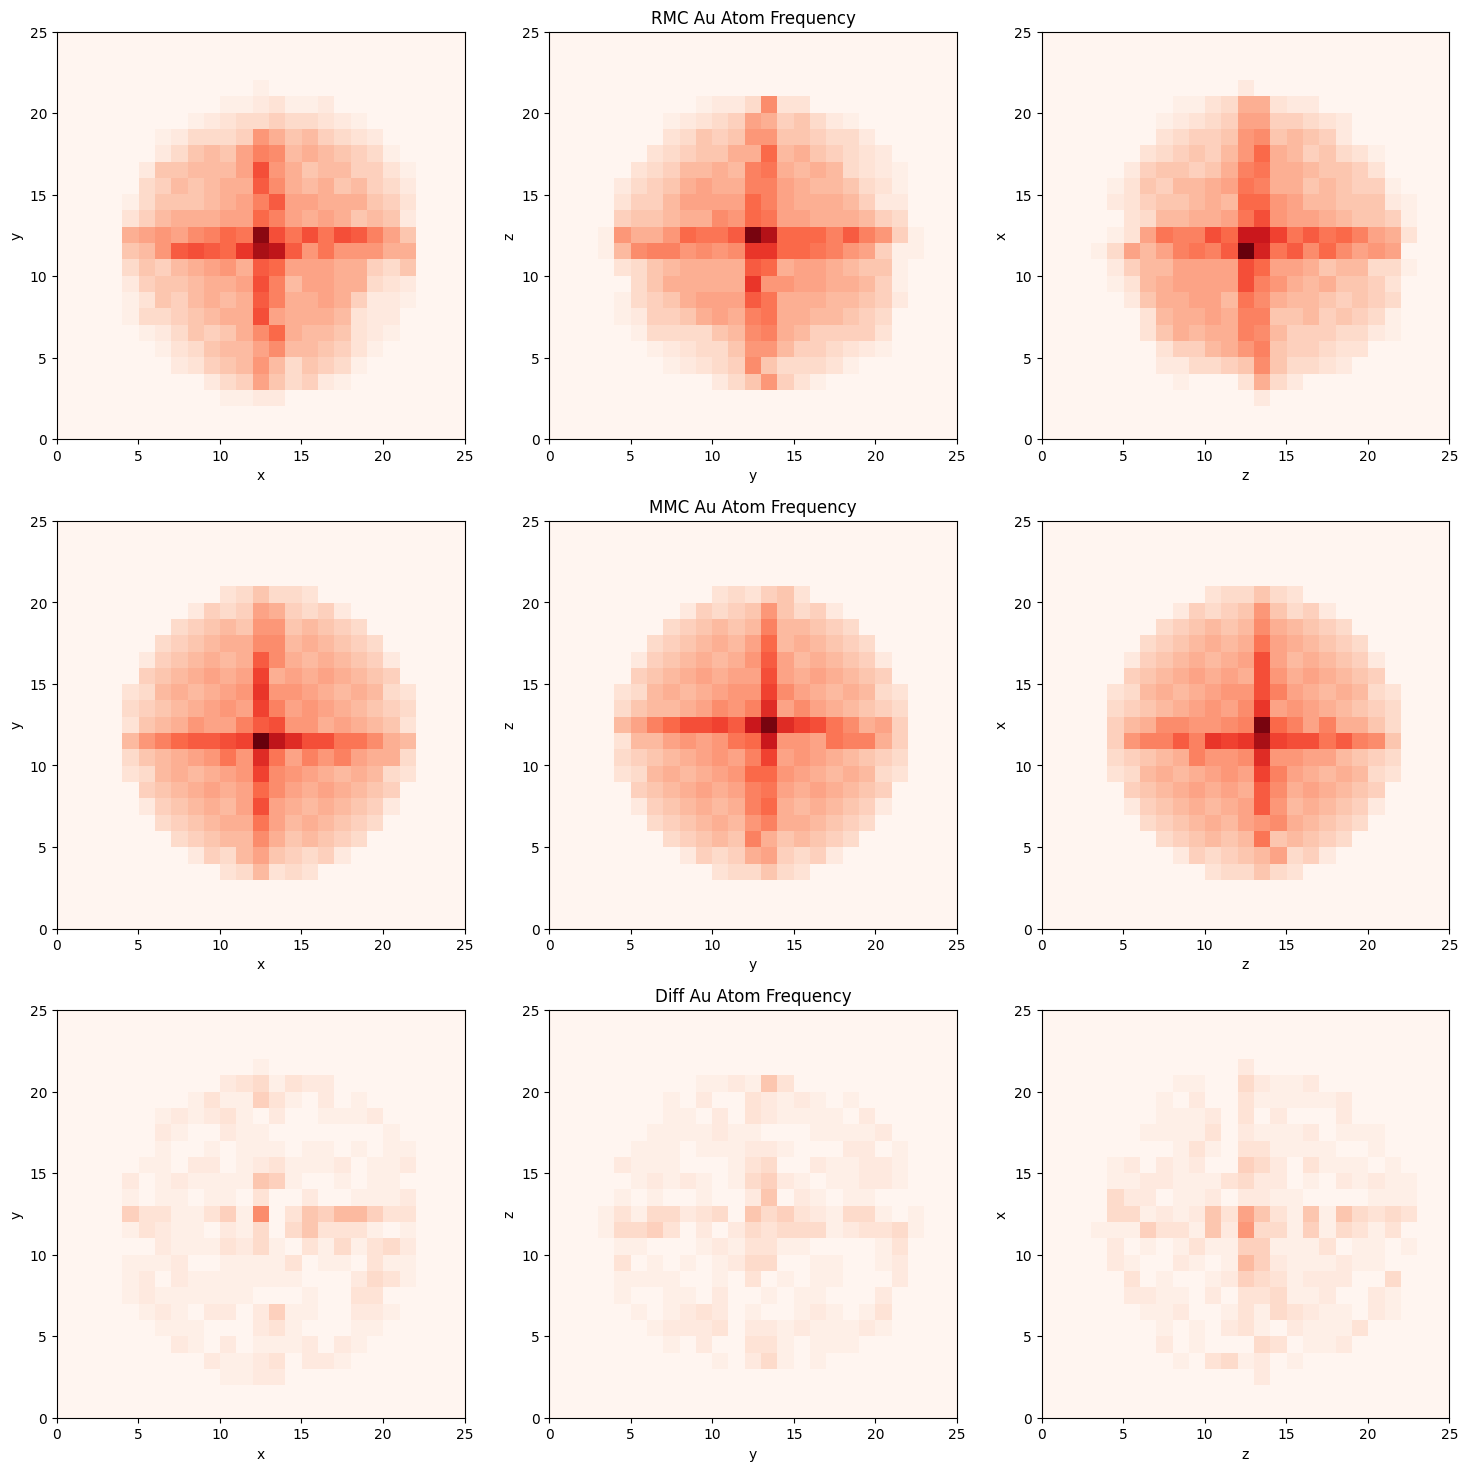

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_Au_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC Au Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_Au_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_Au_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_Au_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC Au Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_Au_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_Au_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_Au_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff Au Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_Au_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_Au_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

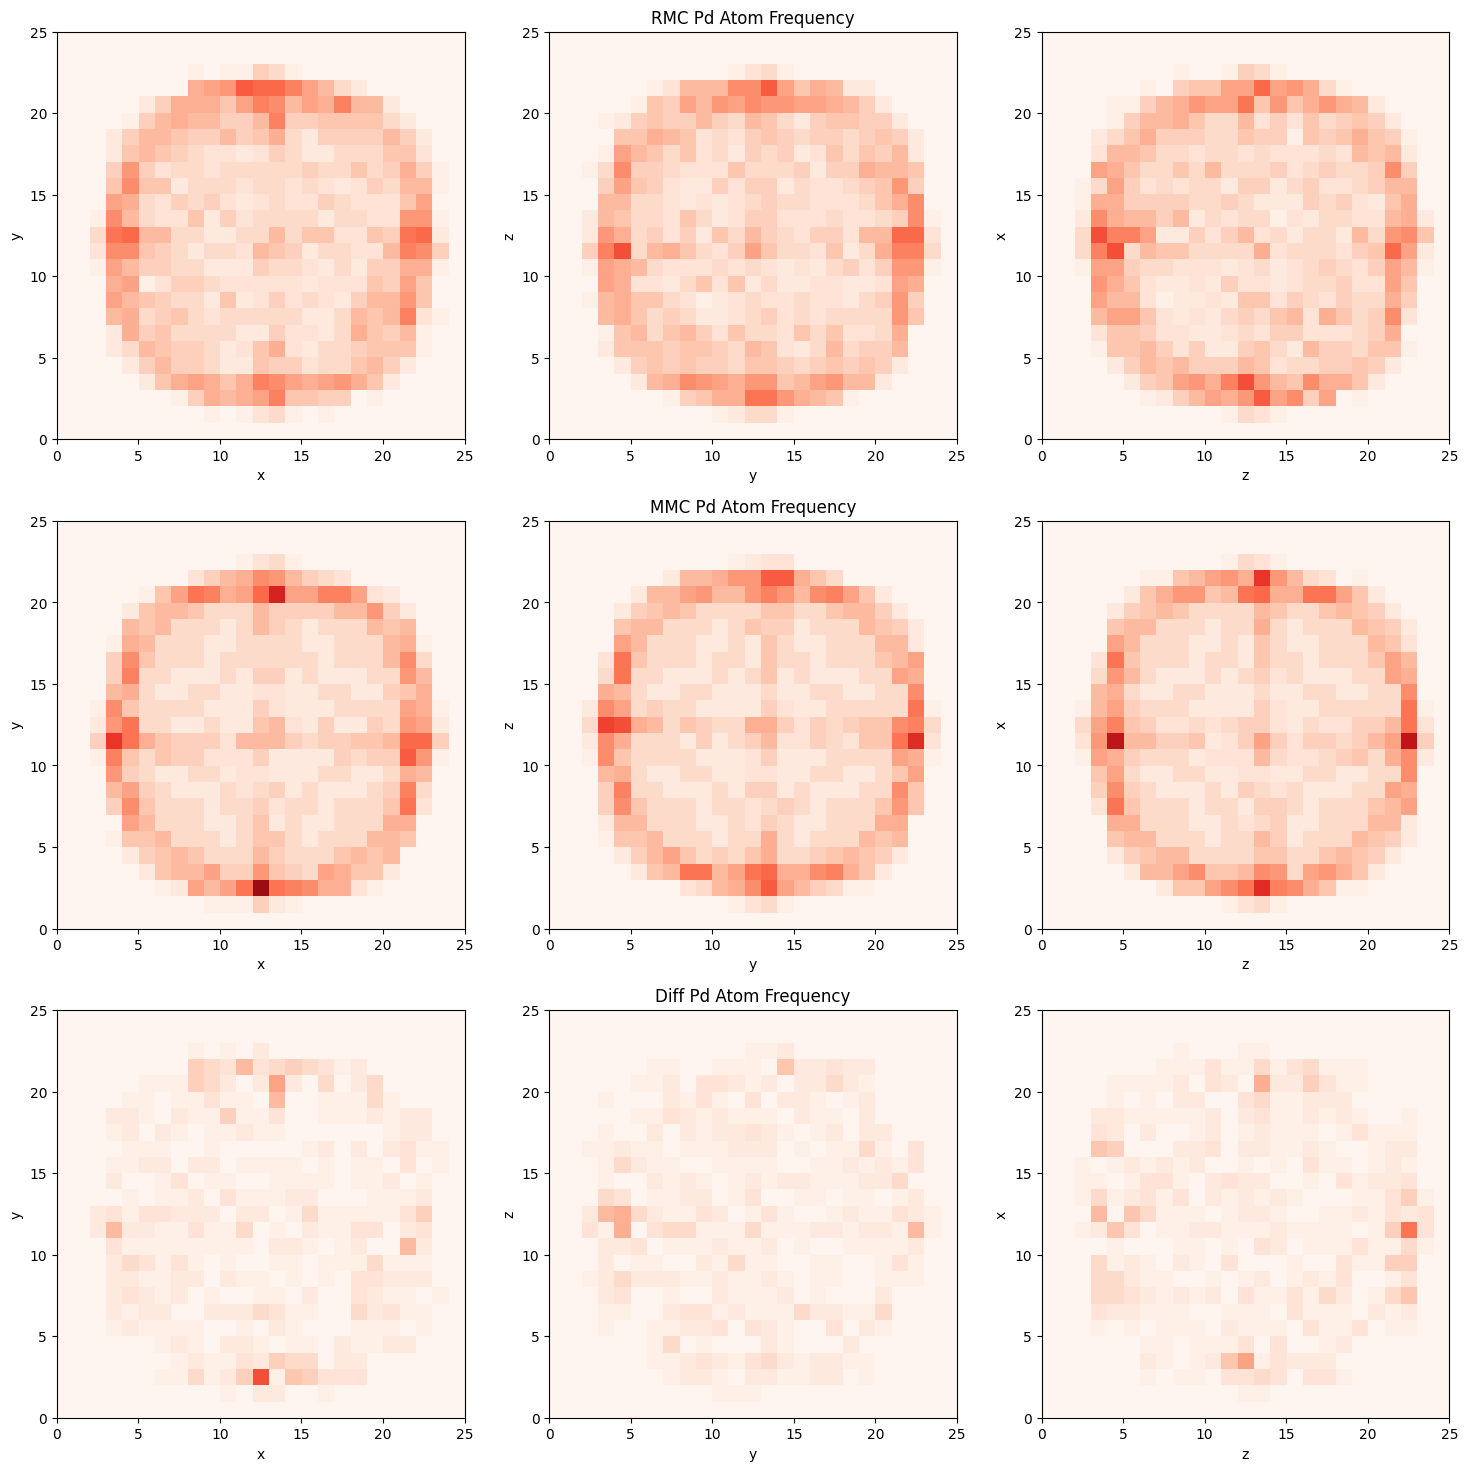

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_Pd_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC Pd Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_Pd_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_Pd_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_Pd_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC Pd Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_Pd_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_Pd_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_Pd_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff Pd Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_Pd_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_Pd_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

### Convert Binned Data into 2D arrays (With Slice through sphere)

In [ ]:
MMC_Au_xy = np.zeros((numbin,numbin))
MMC_Pd_xy = np.zeros((numbin,numbin))
RMC_Au_xy = np.zeros((numbin,numbin))
RMC_Pd_xy = np.zeros((numbin,numbin))
MMC_Au_yz = np.zeros((numbin,numbin))
MMC_Pd_yz = np.zeros((numbin,numbin))
RMC_Au_yz = np.zeros((numbin,numbin))
RMC_Pd_yz = np.zeros((numbin,numbin))
MMC_Au_zx = np.zeros((numbin,numbin))
MMC_Pd_zx = np.zeros((numbin,numbin))
RMC_Au_zx = np.zeros((numbin,numbin))
RMC_Pd_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_Au_xy[x][y] = len(MMC_data_Au.loc[(MMC_data_Au["xbin"]==i) & (MMC_data_Au["ybin"]==j) & (MMC_data_Au["zbin"]<1) & (MMC_data_Au["zbin"]>-1)])
      MMC_Pd_xy[x][y] = len(MMC_data_Pd.loc[(MMC_data_Pd["xbin"]==i) & (MMC_data_Pd["ybin"]==j) & (MMC_data_Pd["zbin"]<1) & (MMC_data_Pd["zbin"]>-1)])
      RMC_Au_xy[x][y] = len(RMC_data_Au.loc[(RMC_data_Au["xbin"]==i) & (RMC_data_Au["ybin"]==j) & (MMC_data_Au["zbin"]<1) & (MMC_data_Au["zbin"]>-1)])
      RMC_Pd_xy[x][y] = len(RMC_data_Pd.loc[(RMC_data_Pd["xbin"]==i) & (RMC_data_Pd["ybin"]==j) & (MMC_data_Pd["zbin"]<1) & (MMC_data_Pd["zbin"]>-1)])

      MMC_Au_yz[x][y] = len(MMC_data_Au.loc[(MMC_data_Au["ybin"]==i) & (MMC_data_Au["zbin"]==j) & (MMC_data_Au["xbin"]<1) & (MMC_data_Au["xbin"]>-1)])
      MMC_Pd_yz[x][y] = len(MMC_data_Pd.loc[(MMC_data_Pd["ybin"]==i) & (MMC_data_Pd["zbin"]==j) & (MMC_data_Pd["xbin"]<1) & (MMC_data_Pd["xbin"]>-1)])
      RMC_Au_yz[x][y] = len(RMC_data_Au.loc[(RMC_data_Au["ybin"]==i) & (RMC_data_Au["zbin"]==j) & (MMC_data_Au["xbin"]<1) & (MMC_data_Au["xbin"]>-1)])
      RMC_Pd_yz[x][y] = len(RMC_data_Pd.loc[(RMC_data_Pd["ybin"]==i) & (RMC_data_Pd["zbin"]==j) & (MMC_data_Pd["xbin"]<1) & (MMC_data_Pd["xbin"]>-1)])

      MMC_Au_zx[x][y] = len(MMC_data_Au.loc[(MMC_data_Au["zbin"]==i) & (MMC_data_Au["xbin"]==j) & (MMC_data_Au["ybin"]<1) & (MMC_data_Au["ybin"]>-1)])
      MMC_Pd_zx[x][y] = len(MMC_data_Pd.loc[(MMC_data_Pd["zbin"]==i) & (MMC_data_Pd["xbin"]==j) & (MMC_data_Pd["ybin"]<1) & (MMC_data_Pd["ybin"]>-1)])
      RMC_Au_zx[x][y] = len(RMC_data_Au.loc[(RMC_data_Au["zbin"]==i) & (RMC_data_Au["xbin"]==j) & (MMC_data_Au["ybin"]<1) & (MMC_data_Au["ybin"]>-1)])
      RMC_Pd_zx[x][y] = len(RMC_data_Pd.loc[(RMC_data_Pd["zbin"]==i) & (RMC_data_Pd["xbin"]==j) & (MMC_data_Pd["ybin"]<1) & (MMC_data_Pd["ybin"]>-1)])
    except:
      None
    y+=1
  x+=1

In [ ]:
diff_Au_xy = np.absolute(np.array(MMC_Au_xy) - np.array(RMC_Au_xy))
diff_Au_yz = np.absolute(np.array(MMC_Au_yz) - np.array(RMC_Au_yz))
diff_Au_zx = np.absolute(np.array(MMC_Au_zx) - np.array(RMC_Au_zx))

diff_Pd_xy = np.absolute(np.array(MMC_Pd_xy) - np.array(RMC_Pd_xy))
diff_Pd_yz = np.absolute(np.array(MMC_Pd_yz) - np.array(RMC_Pd_yz))
diff_Pd_zx = np.absolute(np.array(MMC_Pd_zx) - np.array(RMC_Pd_zx))

In [ ]:
vmin = 0
vmax = np.array([MMC_Au_xy.max(), MMC_Pd_xy.max(), RMC_Au_xy.max(), RMC_Pd_xy.max(), MMC_Au_yz.max(), MMC_Pd_yz.max(), RMC_Au_yz.max(), RMC_Pd_yz.max(), MMC_Au_zx.max(), MMC_Pd_zx.max(), RMC_Au_zx.max(), RMC_Pd_zx.max()]).max()
print(vmax)

8.0


### Plot Binned Data (Frequency Plots)

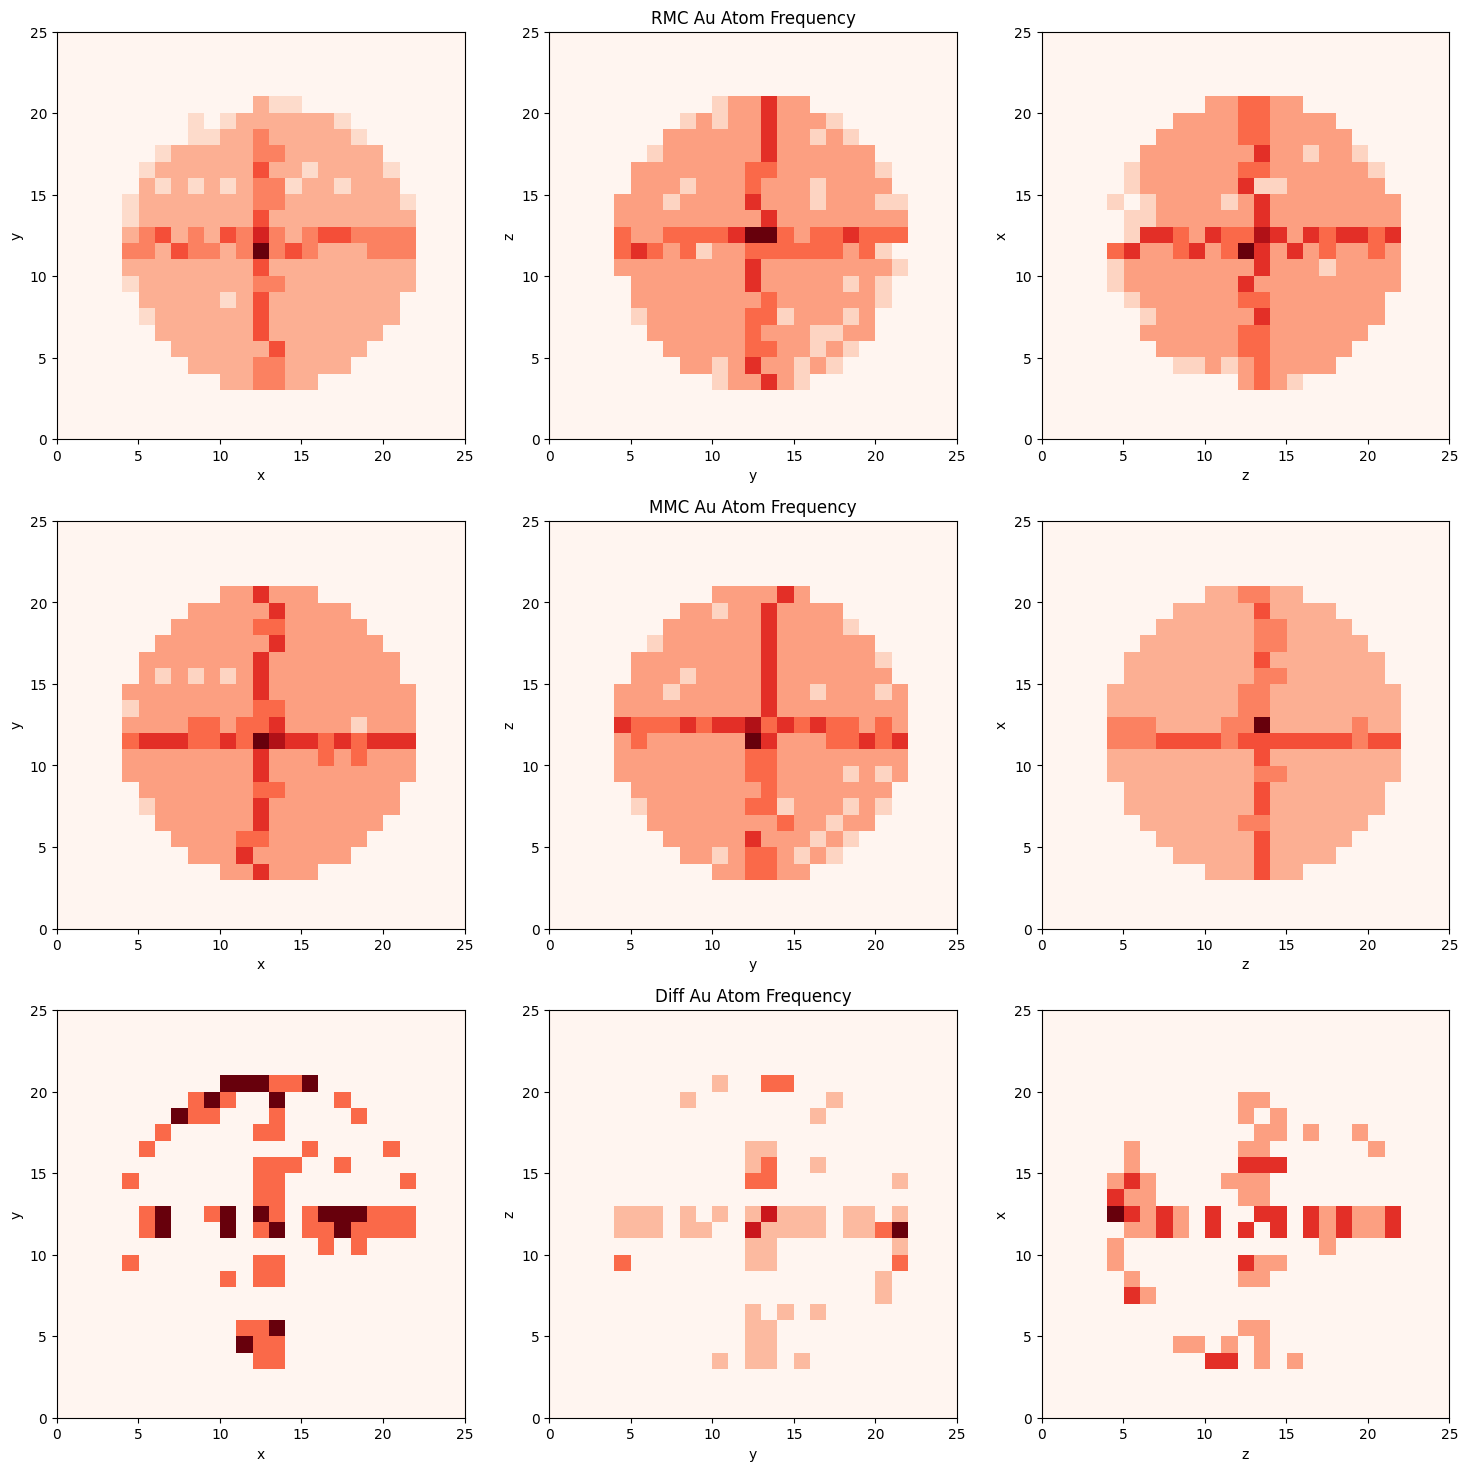

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_Au_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC Au Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_Au_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_Au_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_Au_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC Au Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_Au_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_Au_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_Au_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff Au Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_Au_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_Au_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

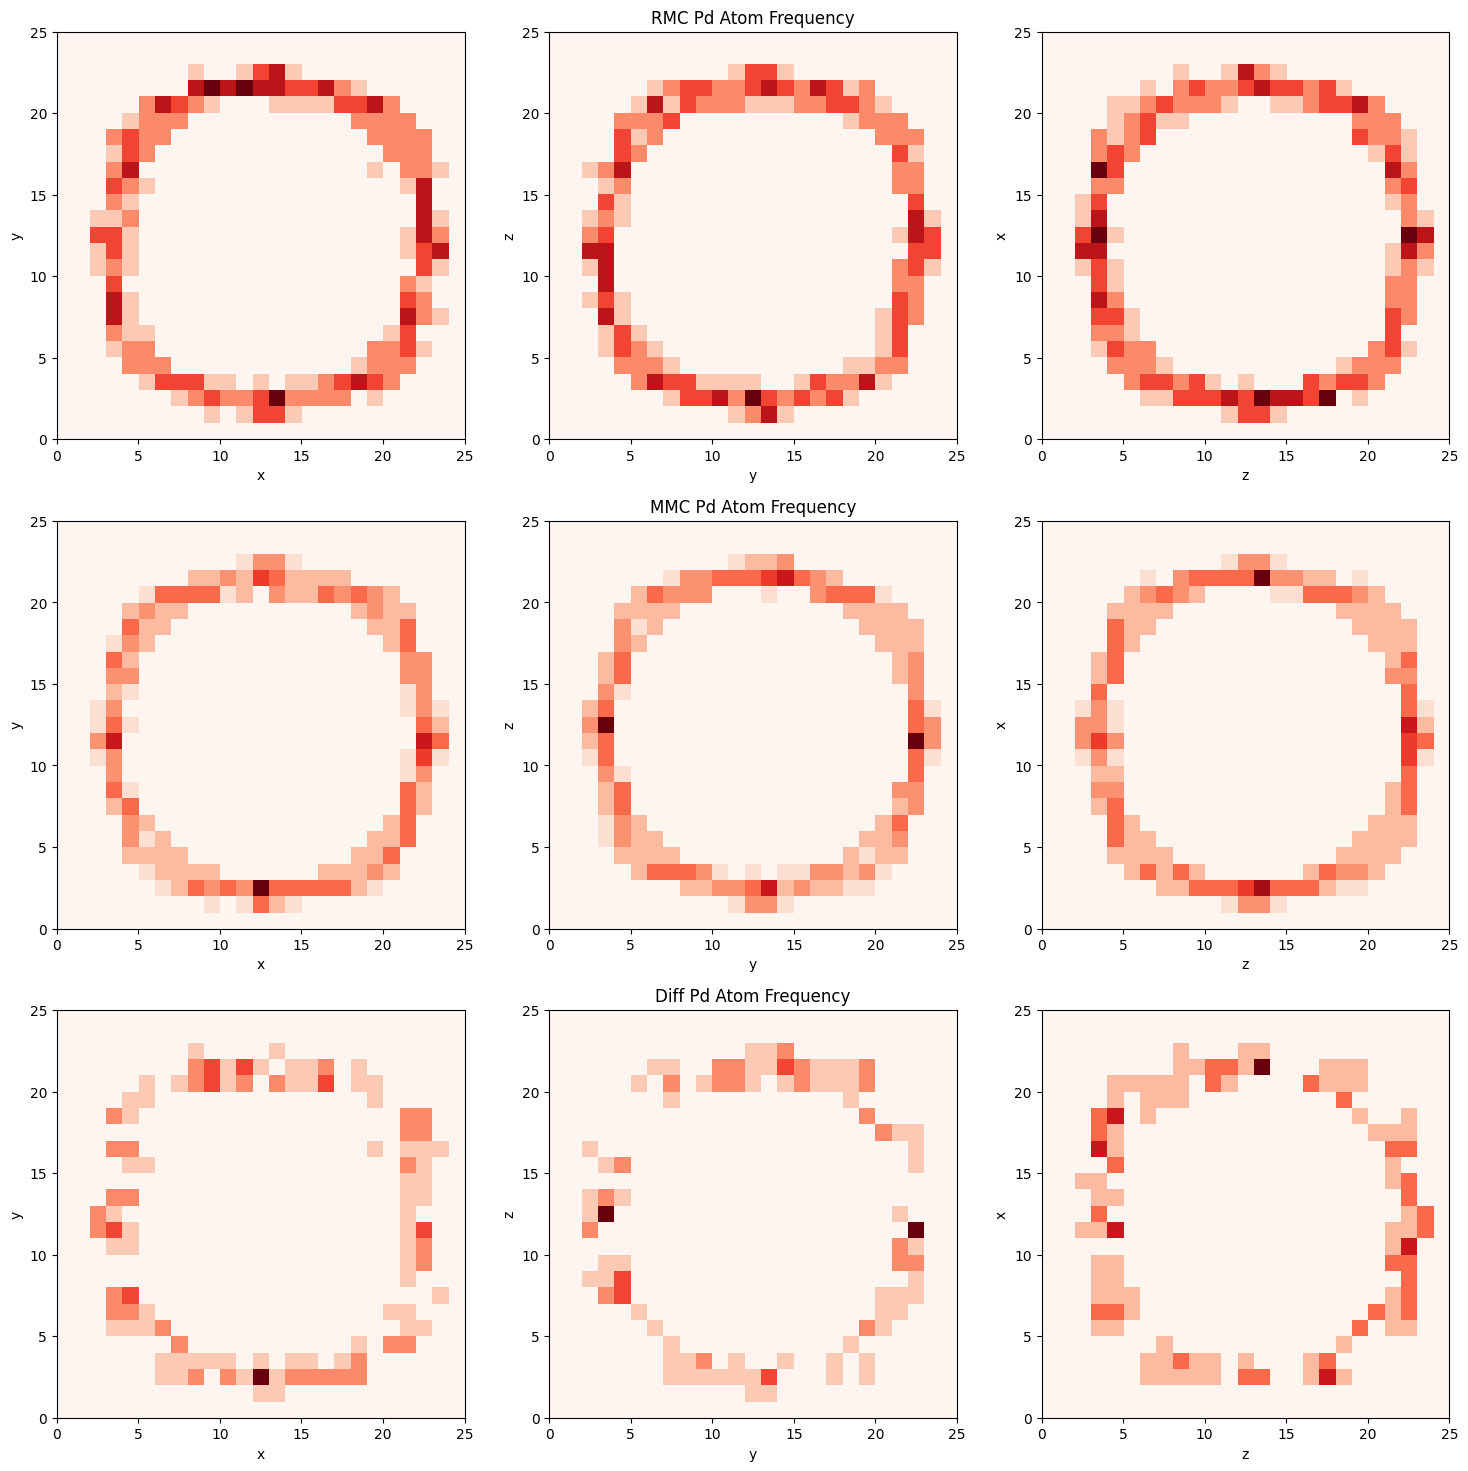

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_Pd_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC Pd Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_Pd_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_Pd_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_Pd_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC Pd Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_Pd_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_Pd_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_Pd_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff Pd Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_Pd_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_Pd_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

## 2D Composition Plot

Indicates the composition of the reconstructed sphere through the volume that each 2D bin corresponds to

### Convert Binned Data ino 2D Arrays

In [ ]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]=="AU")]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]=="AU")]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]=="AU")]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]=="AU")]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]=="AU")]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]=="AU")]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

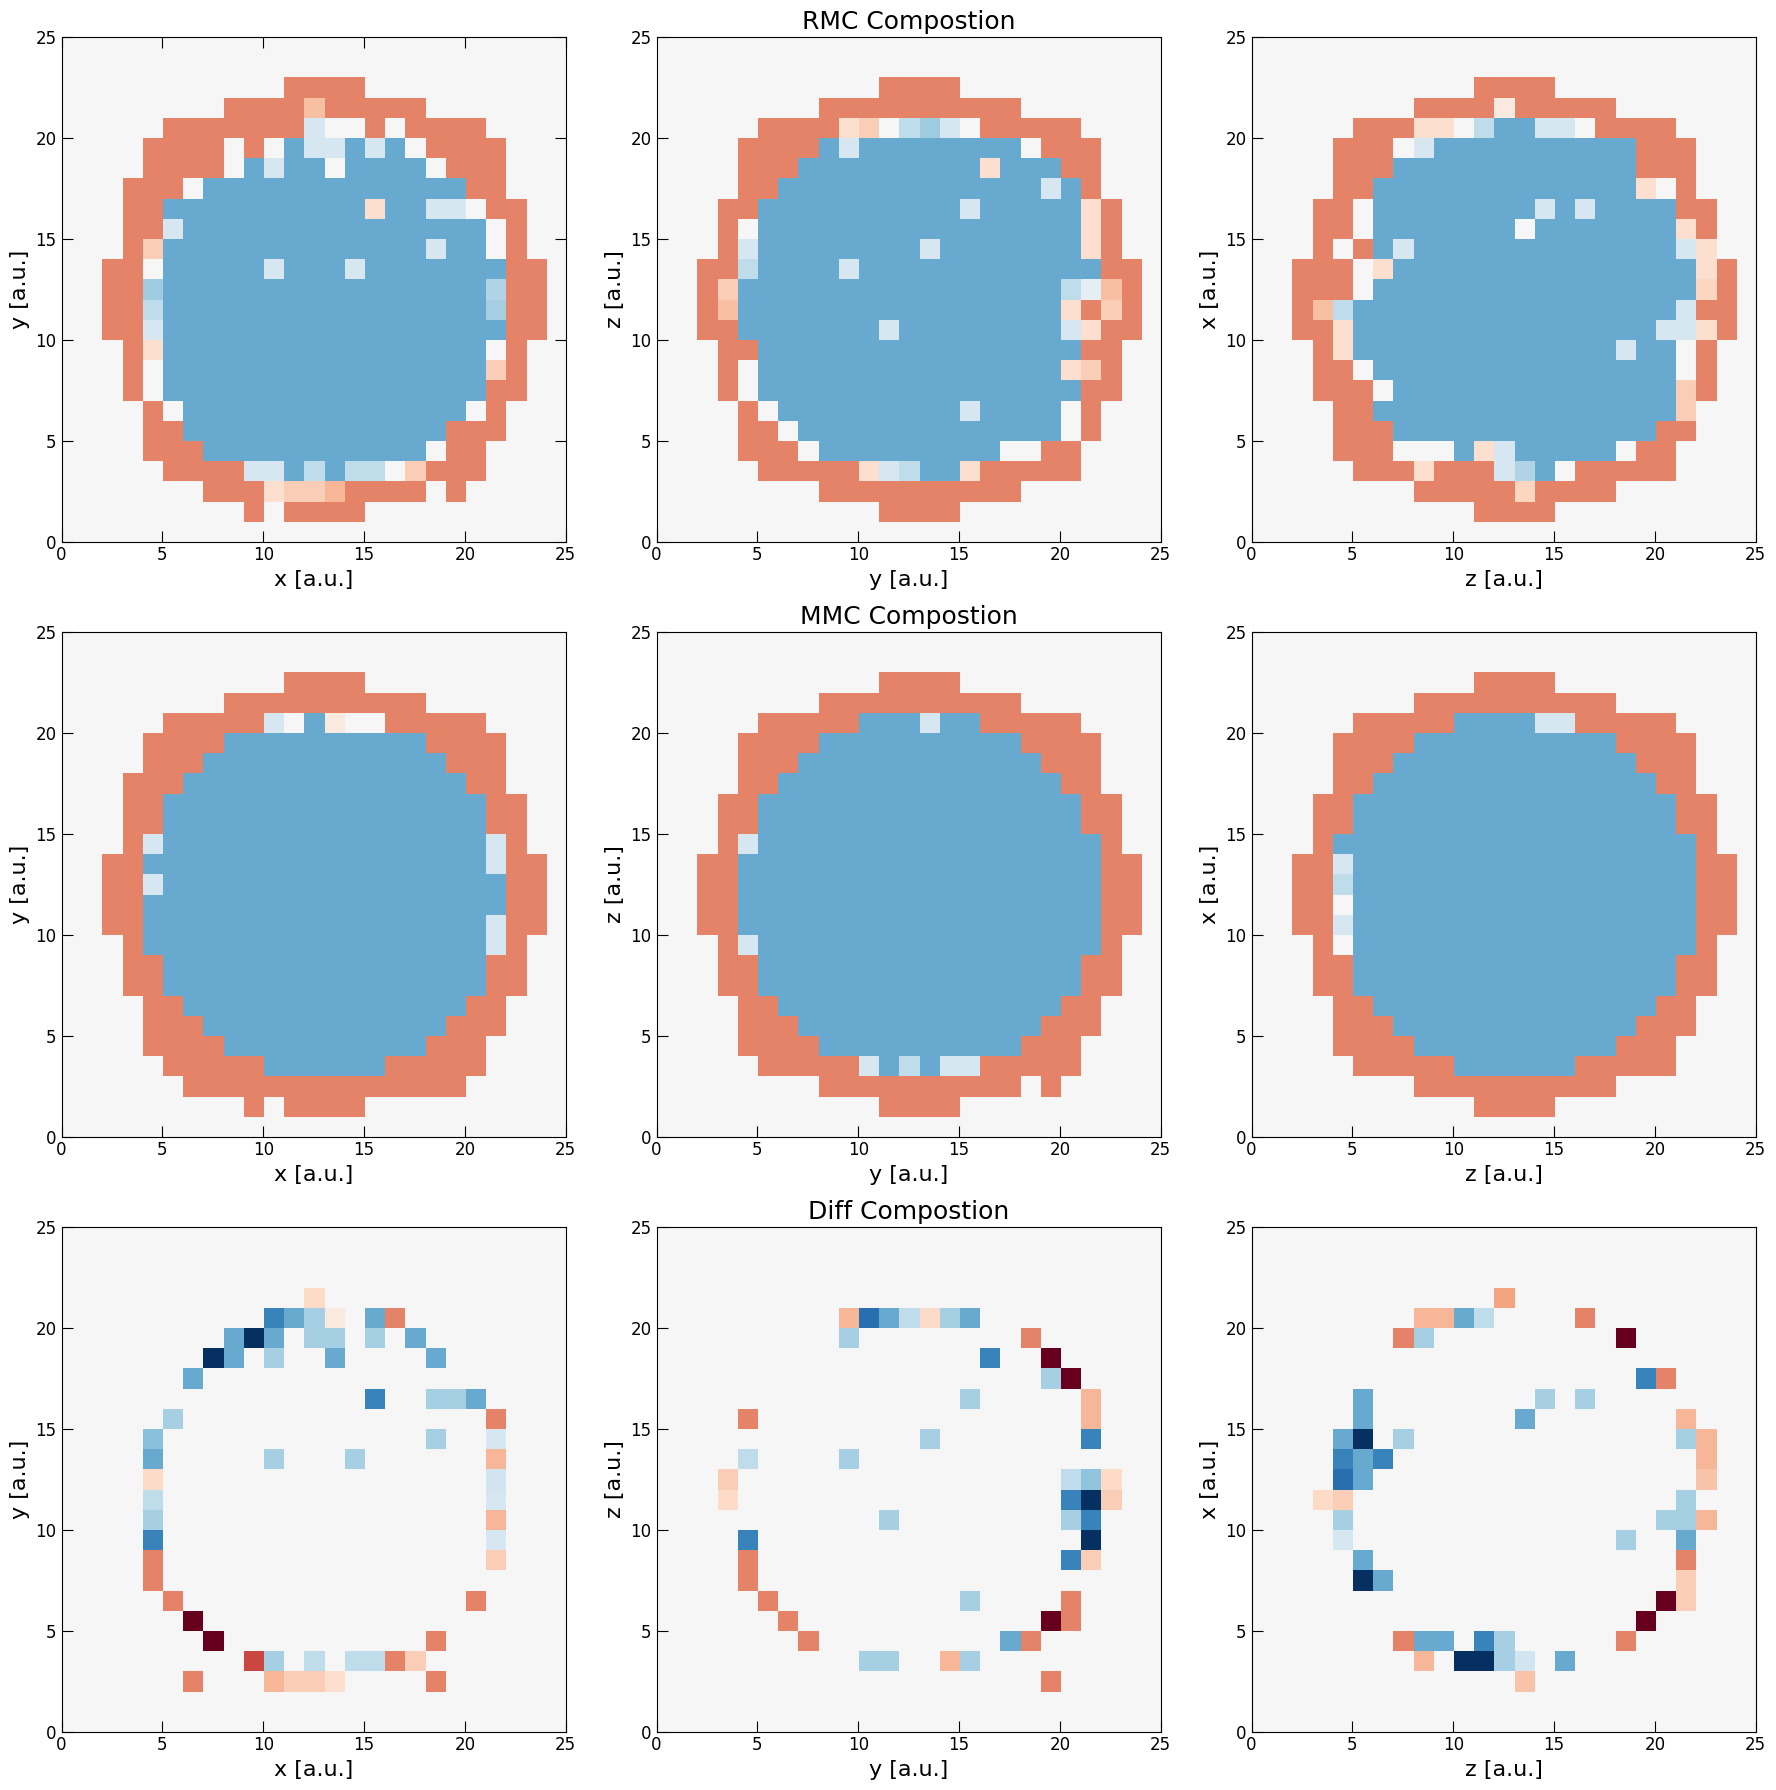

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
###
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x [a.u.]", fontsize=16)
axs[0,0].set_ylabel("y [a.u.]", fontsize=16)
axs[0,0].tick_params(bottom=True, top=True, left=True, right=True)
axs[0,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[0,1].set_title("RMC Compostion", fontsize=18)
axs[0,1].set_xlabel("y [a.u.]", fontsize=16)
axs[0,1].set_ylabel("z [a.u.]", fontsize=16)
axs[0,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z [a.u.]", fontsize=16)
axs[0,2].set_ylabel("x [a.u.]", fontsize=16)
axs[0,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x [a.u.]", fontsize=16)
axs[1,0].set_ylabel("y [a.u.]", fontsize=16)
axs[1,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[1,1].set_title("MMC Compostion", fontsize=18)
axs[1,1].set_xlabel("y [a.u.]", fontsize=16)
axs[1,1].set_ylabel("z [a.u.]", fontsize=16)
axs[1,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z [a.u.]", fontsize=16)
axs[1,2].set_ylabel("x [a.u.]", fontsize=16)
axs[1,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x [a.u.]", fontsize=16)
axs[2,0].set_ylabel("y [a.u.]", fontsize=16)
axs[2,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[2,1].set_title("Diff Compostion", fontsize=18)
axs[2,1].set_xlabel("y [a.u.]", fontsize=16)
axs[2,1].set_ylabel("z [a.u.]", fontsize=16)
axs[2,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z [a.u.]", fontsize=16)
axs[2,2].set_ylabel("x [a.u.]", fontsize=16)
axs[2,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
plt.tight_layout()

## 2D Composition Plot of Slice

### Convert Binned Data into 2D Arrays

In [ ]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]=="AU") & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]=="AU") & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]=="AU") & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]=="AU") & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]=="AU") & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]=="AU") & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

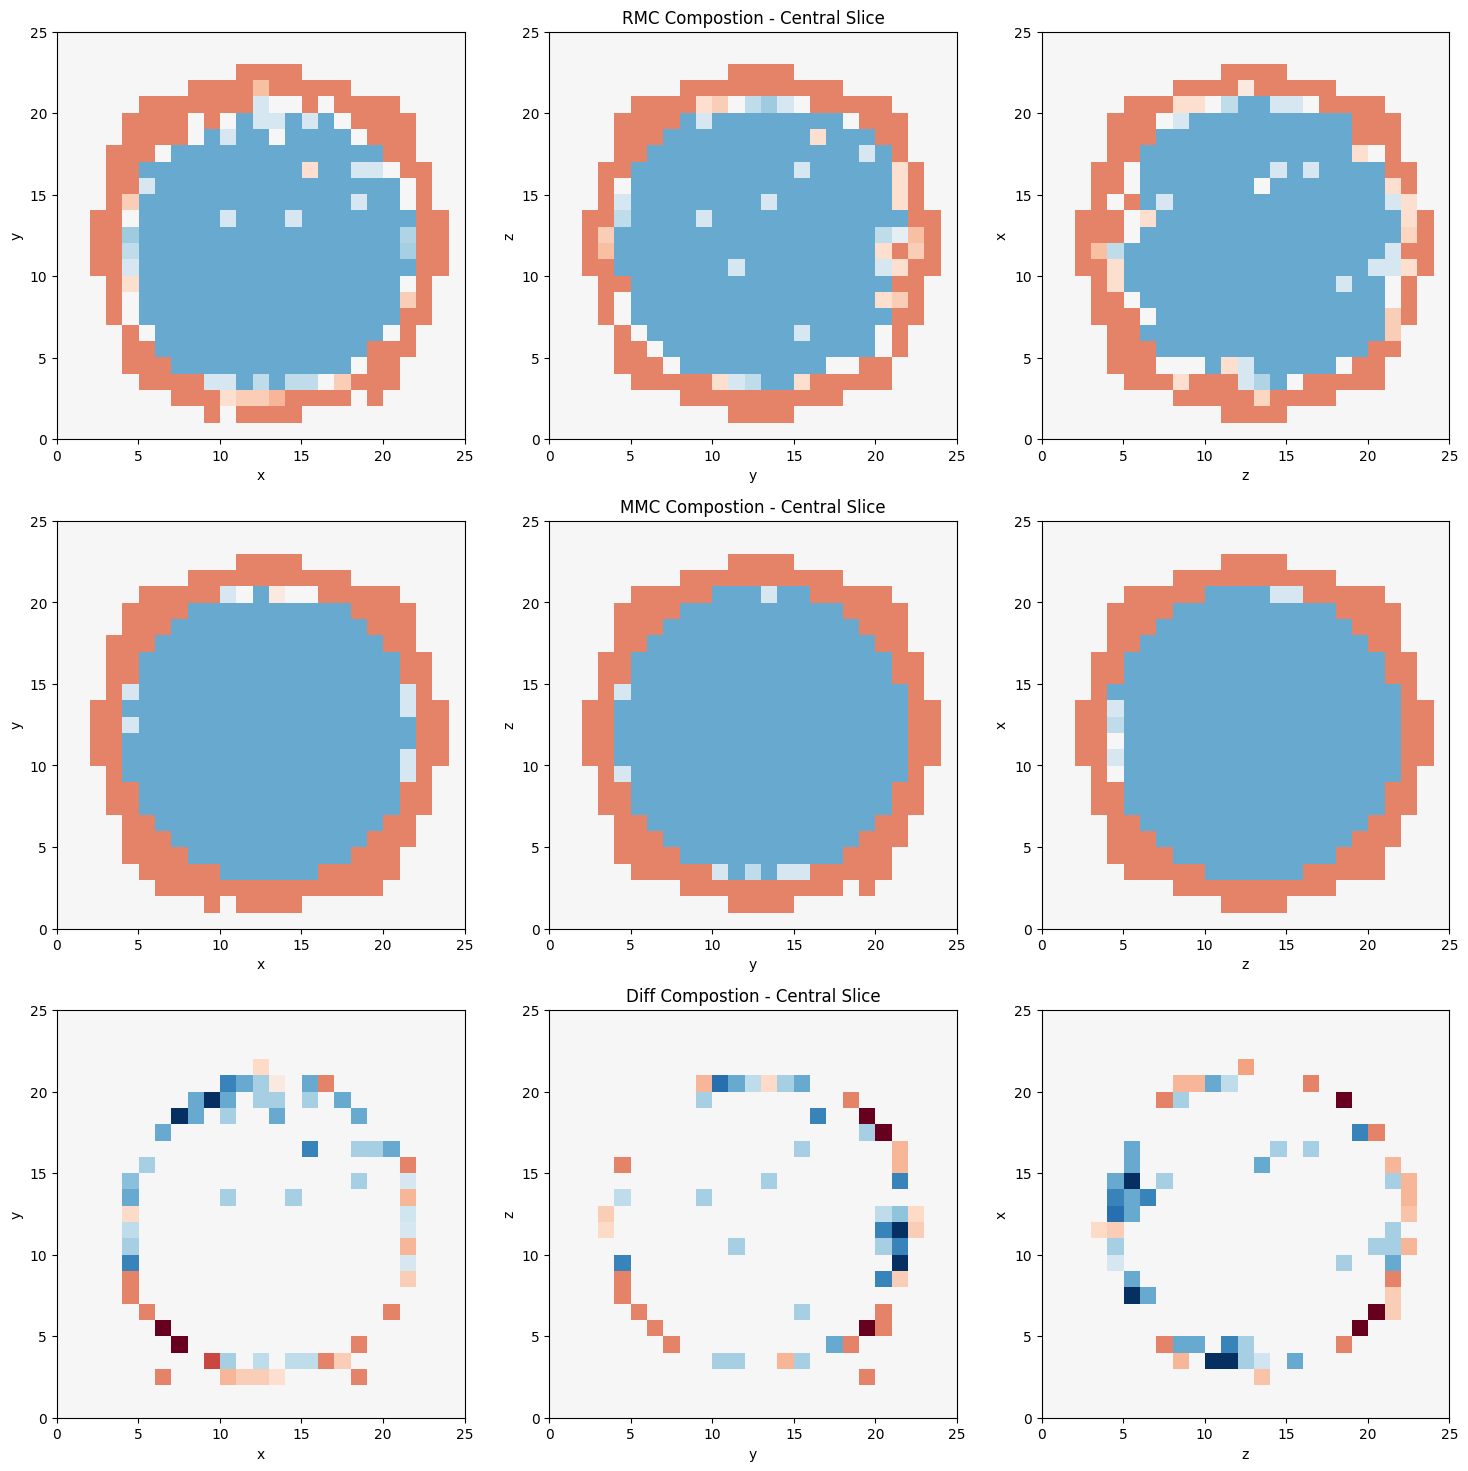

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[0,1].set_title("RMC Compostion - Central Slice")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[1,1].set_title("MMC Compostion - Central Slice")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[2,1].set_title("Diff Compostion - Central Slice")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))